In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0
%load_ext autoreload
%autoreload 2


In [3]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,concatenate,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose, BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras.datasets import fashion_mnist
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from preprocess import ArtDataPreprocessor


In [4]:
data_dir = '../wikiart'
classes = ['Cubism', 'Mannerism_Late_Renaissance']
preprocessor = ArtDataPreprocessor(data_dir, classes)

# get preprocessed train and test data
train_data, train_labels = preprocessor.get_train_data()
test_data, test_labels = preprocessor.get_test_data()
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

In [5]:
# # Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (2811, 224, 224, 3)
Test set (images) shape: (703, 224, 224, 3)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
# Create dictionary of target classes
label_dict = preprocessor.idx_to_class


(224, 224, 3)


Text(0.5, 1.0, '(Label: Cubism)')

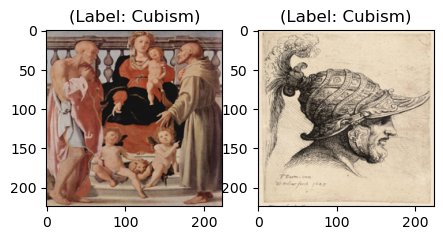

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
print(train_data[1].shape)
curr_img = np.reshape(train_data[1], (224,224,3))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[1], (224,224,3))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


In [9]:
train_data.dtype, test_data.dtype
train_data.shape, test_data.shape

((2811, 224, 224, 3), (703, 224, 224, 3))

In [10]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)


In [11]:
batch_size = 64
epochs = 2
inChannel = 3
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))
num_classes = 2


In [12]:
def encoder(input_img):
    #encoder
    #input = 224 x 224 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #224 x 224 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #112 x 112 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #112 x 112 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #56 x 56 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #56 x 56 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #28 x 28 x 64
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #28 x 28 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #28 x 28 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up3 = UpSampling2D((2,2))(conv5) #56 x 56 x 64
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3) #56 x 56 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #112 x 112 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 112 x 112 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 224 x 224 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 224 x 224 x 1
    return decoded


In [13]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [14]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0     

In [15]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/2
36/36 [==============================] - 295s 8s/step - loss: 0.0445 - val_loss: 0.0588
Epoch 2/2
36/36 [==============================] - 306s 9s/step - loss: 0.0225 - val_loss: 0.0588


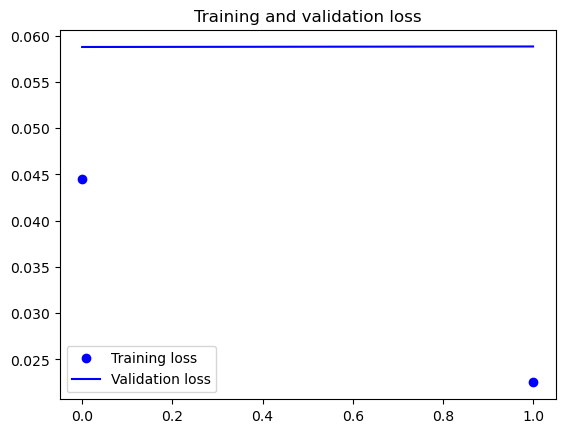

In [16]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(2)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [17]:
autoencoder.save_weights('autoencoder.h5')


In [18]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])


Original label: 1
After conversion to one-hot: [0. 1.]


In [19]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)


In [ ]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape


((2248, 224, 224, 3), (563, 224, 224, 3), (2248, 2), (563, 2))

In [20]:
def encoder(input_img):
    #encoder
    #input = 224 x 224 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #224 x 224 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #112 x 112 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #112 x 112 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #56 x 56 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #56 x 56 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #28 x 28 x 64
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #28 x 28 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4


In [22]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out


In [23]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))


In [24]:
for l1,l2 in zip(full_model.layers[:20],autoencoder.layers[0:20]):
    l1.set_weights(l2.get_weights())


In [25]:
autoencoder.get_weights()[0][1]
full_model.get_weights()[0][1]


array([[[-0.02227909,  0.08500391, -0.04941952, -0.02149824,
         -0.02910387,  0.04922474, -0.112151  , -0.01679171,
          0.06890435, -0.08316873, -0.03717875, -0.05216525,
         -0.08552478, -0.07567758, -0.083516  ,  0.01282947,
          0.10121821,  0.12552904, -0.06099939, -0.13532831,
         -0.06011628,  0.10553101, -0.05004294,  0.08960046,
          0.04034672,  0.00369278, -0.00143043,  0.02779583,
          0.04219899, -0.01202434,  0.05128972,  0.00109217],
        [-0.01118105,  0.08192462,  0.12472675, -0.07241727,
          0.02674337, -0.09767779, -0.03632715,  0.0602071 ,
         -0.09748007,  0.07282123, -0.10089789,  0.04292165,
         -0.0519471 , -0.10395426,  0.07695732,  0.02930749,
         -0.01247018,  0.04400641,  0.03660309,  0.04327065,
         -0.08103293,  0.1283384 ,  0.0391522 ,  0.03332704,
          0.08811284,  0.07603594,  0.11921478, -0.09225941,
          0.13779935,  0.02083416,  0.07422145, -0.06368161],
        [ 0.12428904, 

In [26]:
for layer in full_model.layers[0:20]:
    layer.trainable = False


In [27]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
full_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_22 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_23 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0   

In [28]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=2,verbose=1,validation_data=(valid_X, valid_label))
full_model.save_weights('autoencoder_classification.h5')


Epoch 1/2
36/36 [==============================] - ETA: 0s - loss: 12.6906 - accuracy: 0.6730

In [ ]:
for layer in full_model.layers[0:20]:
    layer.trainable = True
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=2,verbose=1,validation_data=(valid_X, valid_label))
full_model.save_weights('classification_complete.h5')
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


NameError: name 'full_model' is not defined

In [ ]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
predicted_classes = full_model.predict(test_data)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels.shape
correct = np.where(predicted_classes==test_labels)[0]
print "Found %d correct labels" % len(correct)
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()
incorrect = np.where(predicted_classes!=test_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()


In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))
